# Sample 9.2 multivariant linear regression model---Fe lines as a function of M and T

In [1]:
#Check iron line EW as a function of Teff and metallicity for Giant stars
%matplotlib inline
#posteior distribution of binomial data
import numpy as np
import numpy.linalg as nl
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
import astropy.io.fits as fits
from astropy.table import Table
import scipy.special as special
from scipy.optimize import curve_fit

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

# dr3 = Table.read('DR3_Fe_Lines.fits')
# ind_good = (dr3['snrg']>30) & (dr3['snri']>30) & (dr3['teff']>0) & (dr3['logg']>4.8)
# feh = dr3['feh'][ind_good]
# teff = dr3['teff'][ind_good]
# fe5270 = dr3['EW_Fe5270'][ind_good]
# feh_err = dr3['feh_err'][ind_good]
# teff_err = dr3['teff_err'][ind_good]
# fe5270_err = dr3['EWerr_Fe5270'][ind_good]

# c1 = fits.Column(name='feh', array=feh, format='D')
# c2 = fits.Column(name='feh_err', array=feh_err, format='D')
# c3 = fits.Column(name='teff', array=teff, format='D')
# c4 = fits.Column(name='teff_err', array=feh, format='D')
# c5 = fits.Column(name='EWFe', array=fe5270, format='D')
# c6 = fits.Column(name='EWFe_err', array=fe5270_err, format='D')
# t = fits.BinTableHDU.from_columns([c1, c2, c3,c4,c5,c6])
# t.writeto('Fe_lines.fits')

In [49]:
dr3 = Table.read('Fe_lines.fits')
dr3

feh,feh_err,teff,teff_err,EWFe,EWFe_err
float64,float64,float64,float64,float64,float64
-0.15600000321865082,0.06700000166893005,5750.85009765625,-0.15600000321865082,1.981832,0.007464
-0.08399999886751175,0.12800000607967377,5142.31005859375,-0.08399999886751175,3.164041,0.018998
-0.8360000252723694,0.08799999952316284,4615.8701171875,-0.8360000252723694,3.328239,0.00964
0.07199999690055847,0.08399999886751175,4717.1201171875,0.07199999690055847,4.497078,0.011761
-0.20800000429153442,0.07599999755620956,5697.31982421875,-0.20800000429153442,1.611691,0.009536
0.34200000762939453,0.11100000143051147,5922.43994140625,0.34200000762939453,2.809066,0.015595
0.34299999475479126,0.09700000286102295,5938.2099609375,0.34299999475479126,2.760263,0.008908
0.5799999833106995,0.09099999815225601,5928.7998046875,0.5799999833106995,3.100731,0.009304
0.49399998784065247,0.10300000011920929,6039.080078125,0.49399998784065247,2.860287,0.021661


D:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\HONOR\AppData\Local\Temp/ipykernel_10744/3496278609.py:13: UserWarning: Warning: converting a masked element to nan.
  zmap[i,j] = np.median(z[ind])


Text(0.5, 1.0, 'Fe5270 for MS stars')

<Figure size 432x288 with 0 Axes>

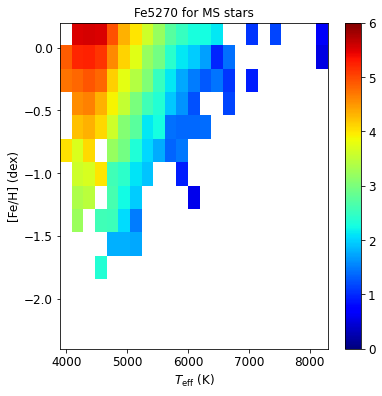

In [16]:
'''
########################################################
derive 2D quantity (median, mean, s.d.) map
########################################################
'''
def z_mean_xy(x,y,z,xgrid,ygrid,mode='median'):
    zmap = np.zeros((len(ygrid)-1,len(xgrid)-1))
    for i in range(len(ygrid)-1):
        for j in range(len(xgrid)-1):
            ind = (x>=xgrid[j]) & (x<xgrid[j+1]) & (y>=ygrid[i]) & (y<ygrid[i+1])
            if np.sum(ind)>0:
                if mode=='median':
                    zmap[i,j] = np.median(z[ind])
                else:
                    if mode=='mean':
                        zmap[i,j] = np.mean(z[ind])
                    else:
                        if mode=='std':
                            zma[i,j] = np.std(z[ind])
                        else:#number
                            zmap[i,j] = np.sum(ind)
            else:
                zmap[i,j] = np.NAN
    return zmap


teffgrid = np.arange(3800,8500,200)
teffcenter = (teffgrid[1:]+teffgrid[:-1])/2.0
fehgrid = np.arange(-2.5,0.5,0.2)
fehcenter = (fehgrid[1:]+fehgrid[:-1])/2.0
teffmesh,fehmesh = np.meshgrid(teffcenter,fehcenter)
mpFe = z_mean_xy(dr3['teff'],dr3['feh'], dr3['EWFe'],teffgrid,fehgrid,mode='median')

plt.set_cmap('jet')
fig = plt.figure(figsize=[6,6])
ax = fig.add_subplot(111)
im = ax.imshow(mpFe,extent=[teffcenter[0],teffcenter[-1],\
        fehcenter[-1],fehcenter[0]],interpolation='none',\
        aspect='auto',vmin=0,vmax=6)
plt.colorbar(im)
ax.set_xlim([teffcenter[0],teffcenter[-1]])
ax.set_ylim([fehcenter[0],fehcenter[-1]])
ax.set_xlabel(r'$T_{\rm eff}$ (K)',fontsize=12)
ax.set_ylabel(r'[Fe/H] (dex)',fontsize=12)
ax.set_title('Fe5270 for MS stars')

In [65]:
x = np.concatenate((np.log10(dr3['teff']).reshape(-1,1),dr3['feh'].reshape(-1,1)),axis=1)[:500,:]
y = dr3['EWFe'][:500]
print(x.shape,y.shape)

(500, 2) (500,)


In [66]:
print(np.sum(np.isnan(y)))

0


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     216.2
Date:                Sun, 08 May 2022   Prob (F-statistic):           2.74e-68
Time:                        14:53:36   Log-Likelihood:                -424.44
No. Observations:                 500   AIC:                             854.9
Df Residuals:                     497   BIC:                             867.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         60.4630      2.797     21.621      0.0

C:\Users\HONOR\AppData\Local\Temp/ipykernel_10744/1053909989.py:49: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Text(0.5, 1.0, 'Model of Fe5270 for MS stars')

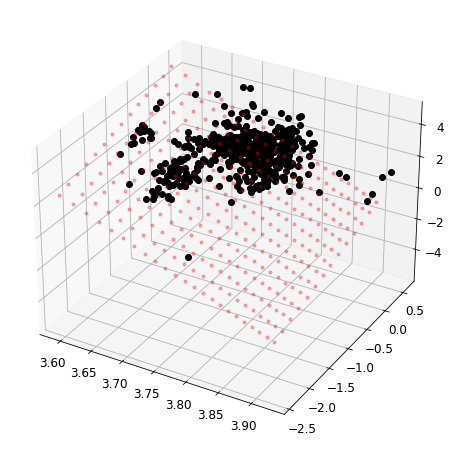

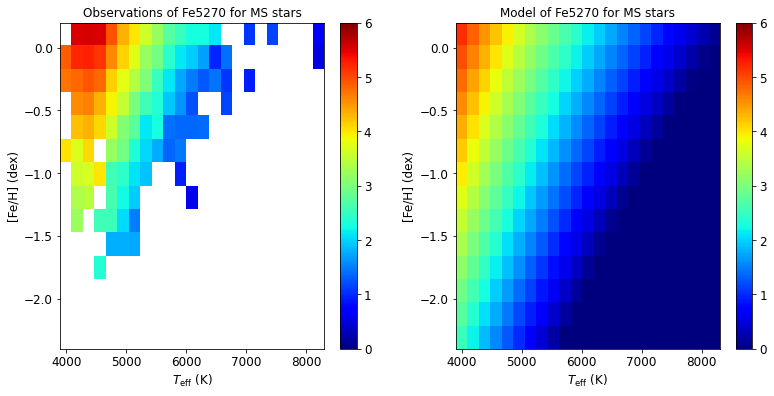

In [78]:
#classical linear regression
def linear(x,a,b):
    return np.sum(x*a,axis=1)+b

#classical linear regression
def regression_stat(x,y):
    N = x.shape[0]
    if len(x.shape)==1:
        ncols = 2
    else:
        ncols = 1+x.shape[1]
    #x = x.reshape(N)
    X = np.zeros((N, ncols))
    X[:,0] = np.ones_like((N,))
    if ncols == 2:
        X[:,1] = x
    else:
        for i in range(1,ncols):
            X[:,i]=x[:,i-1]
    
    model1 = sm.OLS(y,X)
    resul1 = model1.fit()
    #print(resul1)
    print(resul1.summary())
    return resul1
# popt, pcov = curve_fit(linear, x, y)
# print('Classical linear fitting:')
# print('H_0=%(h).1f+/-%(d).1f km/s/Mpc' %\
#     {'h': popt[0], 'd': np.sqrt(pcov[0,0])})

m = regression_stat(x,y)
for i in range(len(m.params)):
    print('%(v).3f+/-%(e).3f' % {'v':m.params[i],'e':m.bse[i]})
print('RMS:',np.sqrt(np.sum((m.predict()-y)**2)/(len(y)-1)))

xgrid = np.concatenate((np.log10(teffmesh.reshape(-1,1)),fehmesh.reshape(-1,1)),axis=1)
ygrid = linear(xgrid,m.params[1:],m.params[0])

fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(111,projection="3d")
ax.plot(x[:,0],x[:,1],y,'ko')
ax.plot(np.log10(teffmesh.flatten()),fehmesh.flatten(),ygrid,'r.',alpha=0.3)
# ax.set_xlabel(r'Distance ($10^6$ parsec)',\
#               fontsize=12)
# ax.set_ylabel(r'radial velocity (km s${-1}$)',\
#              fontsize=12)
# ax.set_xlim([-0.3,2.3])
# ax.set_ylim([-300,1300])
fig.show()

fig = plt.figure(figsize=[13,6])
ax = fig.add_subplot(121)
im = ax.imshow(mpFe,extent=[teffcenter[0],teffcenter[-1],\
        fehcenter[-1],fehcenter[0]],interpolation='none',\
        aspect='auto',vmin=0,vmax=6)
plt.colorbar(im)
ax.set_xlim([teffcenter[0],teffcenter[-1]])
ax.set_ylim([fehcenter[0],fehcenter[-1]])
ax.set_xlabel(r'$T_{\rm eff}$ (K)',fontsize=12)
ax.set_ylabel(r'[Fe/H] (dex)',fontsize=12)
ax.set_title('Observations of Fe5270 for MS stars')

ax = fig.add_subplot(122)
im = ax.imshow(ygrid.reshape(teffmesh.shape),extent=[teffcenter[0],teffcenter[-1],\
        fehcenter[-1],fehcenter[0]],interpolation='none',\
        aspect='auto',vmin=0,vmax=6)
plt.colorbar(im)
ax.set_xlim([teffcenter[0],teffcenter[-1]])
ax.set_ylim([fehcenter[0],fehcenter[-1]])
ax.set_xlabel(r'$T_{\rm eff}$ (K)',fontsize=12)
ax.set_ylabel(r'[Fe/H] (dex)',fontsize=12)
ax.set_title('Model of Fe5270 for MS stars')

V: [[ 2.43091372e+01 -6.46184065e+00  4.16370364e-01]
 [-6.46184065e+00  1.71789200e+00 -1.09901492e-01]
 [ 4.16370364e-01 -1.09901492e-01  1.62433152e-02]]
beta_hat: [ 60.46303523 -15.45365144   1.02077388]
s2: 0.32170729085821065
(10000,)
2.974569929564524
9837 1


C:\Users\HONOR\AppData\Local\Temp/ipykernel_10744/430549738.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


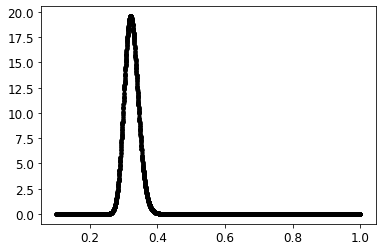

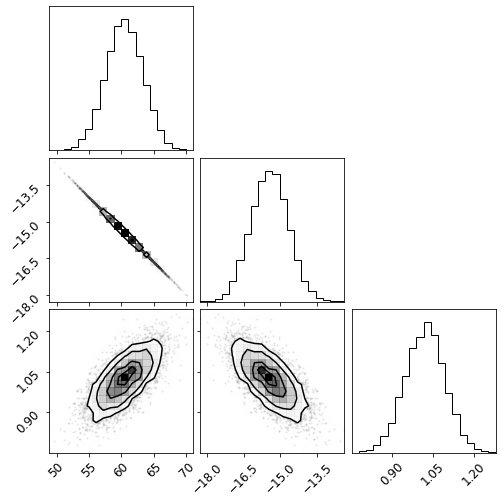

In [97]:
import corner
#Solve with Bayesian normal linear regression
def InvGammaln(x,alpha,beta):
    return np.log(beta)*alpha-(special.gammaln(alpha))+\
           np.log(x)*(-alpha-1)-beta/x

def Scl_InvChi2ln(x, nu, s2):
    return InvGammaln(x, nu/2.,nu/2.*s2)

def randDraw_SInvChi2(nu,s2, N, \
    xmin=100., xmax=2e5, ymin=0., ymax=1, dy=-10.58):
    x = []
    k = 0
    m = 0
    while k<N and m <= 10:
        x0 = np.random.uniform(low=xmin,\
                    high=xmax,size=N*20)
        y0 = np.log(np.random.uniform(\
                    low=ymin,high=ymax,size=N*20))
        y1 = Scl_InvChi2ln(x0, nu, s2)-dy
        ind = (y0<y1)
        x.append(x0[ind])
        k = k + np.sum(ind)
        m += 1
        print(k,m)
    xx = np.array(x).reshape((k,1))
    
    return (xx[0:N])


n = len(y)
k = 3
y1 = y.data
X = np.concatenate((np.ones((n,1)),x),axis=1)

V_beta = nl.inv(np.dot(X.T,X))
beta_hat = np.dot(np.dot(V_beta,X.T),y1)
s2 = 1./(n-k)*np.dot((y1-np.dot(X,beta_hat)).T,\
            (y1-np.dot(X,beta_hat)))
print('V:',V_beta)
print('beta_hat:',beta_hat)
print('s2:',s2)

#test Inv-chi2 to find proper range of y
xx = np.random.uniform(low=0.1,high=1.0,size=10000)

yy = Scl_InvChi2ln(xx, n-k, s2)
print(yy.shape)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xx,np.exp(yy),'k.')
#ax.set_ylim([-100,0])
fig.show()

print(np.max(yy))

#step 1: draw sigma from Inv-Chi2
N = 5000
sigma2 = randDraw_SInvChi2(n-k,s2, N,xmin=0.01,xmax=1.0,ymin=0.,ymax=np.max(yy),dy=0.)
#step 2: draw beta from N(beta_hat, V_beta*sigma^2)
beta = np.array([np.random.\
    multivariate_normal(beta_hat,\
    V_beta*sigma2[i])  for i in range(N)])

fig = corner.corner(beta)
